In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings(action='ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'

import time
from tqdm.notebook import tqdm

import datetime
from datetime import timedelta
import re

import networkx as nx
import chart_studio
chart_studio.tools.set_credentials_file(username='username', api_key='api_key')
import chart_studio.plotly as py
import plotly.express as px
from matplotlib import font_manager, rc

rc('font',family = 'Malgun Gothic')
plt.style.use('ggplot')

- 동부구치소 , 성북구교회 , 해외 제거

- 일일 확진자는 데이터 유지    
- x에는 뺀 것 안뺀것 두개
- 5월데이터도 제거 ( smoothing은 미리 만들어놓고 지우기 )

In [3]:
data = pd.read_excel('network.xlsx')
del data['Unnamed: 0']
data['virus_route'].value_counts().head(50)

기타확진자                   5524
감염경로조사중                 3536
타시도확진자                   844
동부구치소                    744
확인중                      735
해외                       648
성북구사랑제일교회                636
강서구교회                    244
종로구소재파고다타운               224
강서구댄스교습관련시설              209
구로구소재요양병원                175
이태원클럽                    139
리치웨이                     119
서초구사우나Ⅱ                   82
서초구사우나                    77
용산구소재건설현장                 77
용인시우리제일교회                 74
동대문구지혜병원                  70
도봉구다나병원                   68
동대문구고등학교(마포구홍대새교회관련)      65
송파구소재장애인거주시설              65
강남구헬스장                    65
소재                        61
구로구콜센터                    61
동대문구에이스희망케어센터             60
중랑구소재종교시설                 59
광화문집회                     56
중랑구실내체육시설Ⅱ                50
강남구럭키사우나                  45
노원구빛가온교회                  44
중구소재시장(남대문시장)             43
도심                        43
양천구운동시설                   43
요양시설                      43
성북구체대입시       

In [4]:
len(data)

18964

In [5]:
large = ['동부구치소','성북구사랑제일교회','해외']
data = data[~data['virus_route'].isin(large)].reset_index(drop=True)
data

,거주지,날짜,세부정보,퇴원현황,환자번호,virus_route
0,종로구,2020-01-30,이동경로 공개기간 경과,퇴원,6,3
1,종로구,2020-01-31,이동경로 공개기간 경과,퇴원,11,6
2,성북구,2020-01-31,이동경로 공개기간 경과,퇴원,9,5
3,종로구,2020-01-31,이동경로 공개기간 경과,퇴원,10,6
4,성북구,2020-02-05,이동경로 공개기간 경과,퇴원,21,6
...,...,...,...,...,...,...
16931,도봉구,2020-12-31,기타 확진자 접촉,입원,61339,기타확진자
16932,중랑구,2020-12-31,기타 확진자 접촉,입원,60792,기타확진자
16933,광진구,2020-12-31,기타 확진자 접촉,입원,61634,기타확진자
16934,강북구,2020-12-31,감염경로 조사중,입원,61043,감염경로조사중


### Make Complexity Metrics

In [6]:
def Measure(data, start_month, start_day , time_delta,rep):  
   
    day = pd.to_datetime("2020-"+str(start_month).zfill(2)+"-"+str(start_day))  # 시작날짜 초기화
    start = day - timedelta(days=3)
    end = day + timedelta(days=3)
    output = pd.DataFrame() # 시기별 중심성지표 빈 데이터프레임 만들기
    
    def density(graph):
        if len(graph.edges()) <2:
            return 0
        else:
            return len(graph.edges()) / (len(graph.nodes()) * (len(graph.nodes()) - 1))
    
    def AVG_COEF(graph):
        nodes = list(graph.nodes())
        edges = list(graph.edges())
        
        if len(nodes) < 2:
            return 0 
        else:
            deg = []  # deg()
            for n in nodes:
                a = []
                for i in edges:
                    if i[0] == n:
                        a.append(i[1])   # 각 노드에 대한 degree 구하기
                    elif i[1] == n:
                        a.append(i[0])
                    else:
                        continue

                if len(a) < 2 :
                    deg.append(0)
                else:
                    deg.append(len(edges) / (len(a)*(len(a)-1)))
                
            return sum(deg) / len(nodes)

    def modularity(graph):
        nodes = list(graph.nodes())
        edges = list(graph.edges())
        deg = []
        modular = []
        if len(nodes) < 2 :
            return 0
        else:
            for n in nodes:
                a = []
                for i in edges:
                    if i[0] == n :
                        a.append(i[1])   # 각 노드에 대한 degree 구하기
                    elif i[1] == n:
                        a.append(i[0])
                    else:
                        continue

                deg.append(len(a))

            for i in range(len(deg)):
                for j in range(i+1,len(deg)):
                    modular.append(deg[i]*deg[j] / (2*len(edges)))
                
        return sum(modular) / len(modular)    
    
    ## 그래프 형태에 따른 ADIndex
    def ADIndex_pv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.edges())
        
        if len(nodes) < 2 :
            return 0
        else:
            return 6 / (len(nodes)*(len(nodes)+1))
        
    def ADIndex_sv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.nodes())
        
        if len(nodes) < 2 :
            return 0
        else:
            return 1/(len(nodes)-1)
        
    def ADIndex_cv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.edges())
        
        if len(nodes) < 2 :
            return 0
        elif len(nodes) % 2 == 1:
            return 8/(len(nodes)**2 -1)
        else:
            return 8/(len(nodes)**2)
        
    def B_sv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.nodes())

        if len(nodes) < 2 :
            return 0
        else:
            return (3*len(nodes)-4)/(2*len(nodes)-3)

    def B_cv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.nodes())

        if len(nodes) < 2 :
            return 0
        elif len(nodes) % 2 == 1:
            return 8*len(nodes)/(len(nodes)**2 -1)
        else:
            return 8/(len(nodes))
############################################################################################################

    date = []   
    dense = []
    avg_coef =[]
    modul = []
    ad_pv = []
    ad_sv = []
    ad_cv = []
    b_sv = []
    b_cv = []
    
    for i in range(rep):
        
        df = data[ data['날짜'] >= start][data['날짜'] <=end].reset_index(drop=True) # 시작날짜 ~ 종료날짜 해당하는 DF 추출
        edges = []   # Empty Edge list
        for j in range(len(df)):
            edges.append((str(df['virus_route'][j]),str(df['환자번호'][j]),1)) # Edge 만들기
            
        G = nx.Graph() # 그래프 생성
        G.add_weighted_edges_from(edges) # 그래프 안에서 Edge 연결
        
        date.append(day)
        dense.append(density(G))
        avg_coef.append(AVG_COEF(G))
        modul.append(modularity(G))
        ad_pv.append(ADIndex_pv(G))
        ad_sv.append(ADIndex_sv(G))
        ad_cv.append(ADIndex_cv(G))
        b_sv.append(B_sv(G))
        b_cv.append(B_cv(G))
        day = day + timedelta(days=time_delta)  # 종료날짜다음날부터를 시작날짜로 재설정
        start = day - timedelta(days=3)
        end = day + timedelta(days=3)        
        
    output = pd.DataFrame({'Date' : date , 'Density' : dense, 'AVG_COEF' : avg_coef , 'Modularity' : modul,
                           'AD_Pv' : ad_pv, 'AD_Sv': ad_sv, 'AD_Cv': ad_cv, 'B_Sv':b_sv, 'B_Cv':b_cv})
    

    return output

In [7]:
a = Measure(data, start_month=1, start_day=30 , time_delta=1,rep=337) # 276
a.head()

KeyboardInterrupt: 

### Smoothing

- data shape before processing smoothing

In [7]:
cum = pd.pivot_table(data,index='날짜',aggfunc='count').reset_index().iloc[:,0:2]
cum.rename(columns={'virus_route':'확진자수'},inplace=True)
cum2 = pd.DataFrame({'날짜':pd.date_range(start='1/30/2020', end='12/31/2020')})
cum2 = pd.merge(cum2,cum,how='left').fillna(0)
cum2.rename(columns={'날짜':'Date'},inplace=True)
cum3 = pd.merge(cum2,a,how='left')
cum3.head()

,Date,확진자수,Density,AVG_COEF,Modularity,AD_Pv,AD_Sv,AD_Cv,B_Sv,B_Cv
0,2020-01-30,1.0,0.133333,0.111111,0.208333,0.142857,0.200000,0.222222,1.555556,1.333333
1,2020-01-31,3.0,0.133333,0.111111,0.208333,0.142857,0.200000,0.222222,1.555556,1.333333
2,2020-02-01,0.0,0.133333,0.111111,0.208333,0.142857,0.200000,0.222222,1.555556,1.333333
3,2020-02-02,0.0,0.119048,0.059524,0.185714,0.107143,0.166667,0.166667,1.545455,1.166667
4,2020-02-03,0.0,0.133333,0.111111,0.208333,0.142857,0.200000,0.222222,1.555556,1.333333


- start smoothing

In [8]:
df

NameError: name 'df' is not defined

In [9]:
current_day= []
num = []
density = []
avg_coef = []
modul = []
adpv = []
adsv = []
adcv = []
bsv = []
bcv = []

for i in pd.date_range(start='1/30/2020',end='12/31/2020'):
    day = i
    start = day - timedelta(days=3)
    end = day + timedelta(days=3)
    df = cum3[ cum3['Date'] >= start][cum3['Date'] <=end].reset_index(drop=True)

    current_day.append(day)
    num.append(df['확진자수'].sum()/7)
    density.append(df['Density'].sum()/7)
    avg_coef.append(df['AVG_COEF'].sum()/7)
    modul.append(df['Modularity'].sum()/7)
    adpv.append(df['AD_Pv'].sum()/7)
    adsv.append(df['AD_Sv'].sum()/7)
    adcv.append(df['AD_Cv'].sum()/7)
    bsv.append(df['B_Sv'].sum()/7)
    bcv.append(df['B_Cv'].sum()/7)

In [10]:
len(current_day) , len(num), len(density), len(avg_coef) , len(modul) , len(adpv) , len(adsv), len(adcv) , len(bsv), len(bcv)

(337, 337, 337, 337, 337, 337, 337, 337, 337, 337)

- Final Data

In [140]:
total = pd.DataFrame({'Date' : current_day , 'infected' : num , 'Density' : density , 'AVG_COEF' : avg_coef,
                      'Modularity' : modul , 'AD_Pv' : adpv , 'AD_Sv' : adsv, 'AD_Cv' : adcv , 'B_Sv' : bsv , 'B_Cv' : bcv})

In [141]:
total.head(3)

,Date,infected,Density,AVG_COEF,Modularity,AD_Pv,AD_Sv,AD_Cv,B_Sv,B_Cv
0,2020-01-30,0.571429,0.074150,0.056122,0.115816,0.076531,0.109524,0.119048,0.887446,0.738095
1,2020-01-31,0.571429,0.093197,0.071995,0.145578,0.096939,0.138095,0.150794,1.109668,0.928571
2,2020-02-01,0.571429,0.093197,0.071995,0.217007,0.239796,0.280952,0.436508,1.395382,1.500000


### N주전까지의 확진자 평균 수와 당일 확진자수의 연관성

In [142]:
# N주전 변수 추가 함수 
def add_nweeks_before(data,column,week):
    avg_infected = [] 
    for k in pd.date_range(start='01/30/2020',end='12/31/2020'):
        day = k
        start = day - timedelta(days= week * 7)
        end = day - timedelta(days=1)
        df = data[ data['Date'] >= start][data['Date'] <=end].reset_index(drop=True)
        avg_infected.append(sum(df[column]/(week*7)))
    col_name = str(week)+'week_before_' + column
    data[col_name] = avg_infected
    return data

In [143]:
total.head(3)

,Date,infected,Density,AVG_COEF,Modularity,AD_Pv,AD_Sv,AD_Cv,B_Sv,B_Cv
0,2020-01-30,0.571429,0.074150,0.056122,0.115816,0.076531,0.109524,0.119048,0.887446,0.738095
1,2020-01-31,0.571429,0.093197,0.071995,0.145578,0.096939,0.138095,0.150794,1.109668,0.928571
2,2020-02-01,0.571429,0.093197,0.071995,0.217007,0.239796,0.280952,0.436508,1.395382,1.500000


In [144]:
# 모든 컬럼에 대해 2주전까지의 지표와 상관성을 보기위해서 기존 컬럼들과 n주차 조합을 통해 새로운 데이터 생성하기
colnames = total.columns.tolist()[1:]
nweek = [1,2]

In [145]:
for col in colnames:
    for weeks in nweek:
        total = add_nweeks_before(total , col , weeks)

# 기존 컬럼들 지우기
total = total[total.columns.difference(colnames[1:])] # infected는 남겨

In [146]:
total.head()
len(total.columns) # 19개   = 변수개수(9) * 2 + Date변수

,1week_before_AD_Cv,1week_before_AD_Pv,1week_before_AD_Sv,1week_before_AVG_COEF,1week_before_B_Cv,1week_before_B_Sv,1week_before_Density,1week_before_Modularity,1week_before_infected,2week_before_AD_Cv,2week_before_AD_Pv,2week_before_AD_Sv,2week_before_AVG_COEF,2week_before_B_Cv,2week_before_B_Sv,2week_before_Density,2week_before_Modularity,2week_before_infected,Date,infected
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01-30,0.571429
1,0.017007,0.010933,0.015646,0.008017,0.105442,0.126778,0.010593,0.016545,0.081633,0.008503,0.005466,0.007823,0.004009,0.052721,0.063389,0.005296,0.008273,0.040816,2020-01-31,0.571429
2,0.038549,0.024781,0.035374,0.018303,0.238095,0.285302,0.023907,0.037342,0.163265,0.019274,0.012391,0.017687,0.009151,0.119048,0.142651,0.011953,0.018671,0.081633,2020-02-01,0.571429
3,0.100907,0.059038,0.075510,0.028588,0.452381,0.484642,0.037221,0.068343,0.244898,0.050454,0.029519,0.037755,0.014294,0.226190,0.242321,0.018610,0.034172,0.122449,2020-02-02,0.714286
4,0.204082,0.113703,0.136054,0.038873,0.748299,0.724799,0.050534,0.109548,0.346939,0.102041,0.056851,0.068027,0.019436,0.374150,0.362400,0.025267,0.054774,0.173469,2020-02-03,0.571429


20

### Modeling with linear & nonlinear regression

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [28]:
train = total[(total['Date']>='2020-01-30') & (total['Date']<='2020-11-27')] # 12월 1일 스무딩에 들어가는 11/28 ~ 30 은 제거해줌
test = total[total['Date']>='2020-12-01']

- 1 . Simple Linear Regression

In [29]:
scores = []
coef = []
for i in range(18):
    X_train , y_train = train.iloc[:,i] , train.iloc[:,19] # 20번째 컬럼이 infected y변수
    X_test  , y_test  = test.iloc[:,i] , test.iloc[:,19]
    model = LinearRegression()
    model.fit(np.array(X_train).reshape(-1,1), y_train)
    y_pred = model.predict(np.array(X_test).reshape(-1,1))
    scores.append(mean_squared_error(y_test,y_pred))
    coef.append(model.coef_[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
pd.DataFrame({'var':train.columns[:18], 'mse' : scores , 'coef' : coef}).sort_values(by='mse')

,var,mse,coef
3,1week_before_AVG_COEF,133.515577,9.521162
8,1week_before_infected,138.887713,0.981984
12,2week_before_AVG_COEF,151.956587,10.120328
17,2week_before_infected,258.352418,0.987374
15,2week_before_Density,609.284403,-214.334350
16,2week_before_Modularity,624.289296,-79.705980
6,1week_before_Density,637.991442,-169.570780
13,2week_before_B_Cv,639.280955,-10.247991
7,1week_before_Modularity,641.195299,-68.749607
4,1week_before_B_Cv,656.232839,-8.691830


In [178]:
    X_train , y_train = train.iloc[:,3] , train.iloc[:,19] # 20번째 컬럼이 infected y변수
    X_test  , y_test  = test.iloc[:,3] , test.iloc[:,19]
    model = LinearRegression()
    model.fit(np.array(X_train).reshape(-1,1), y_train)
    y_pred = model.predict(np.array(X_test).reshape(-1,1))
    scores.append(mean_squared_error(y_test,y_pred))
    coef.append(model.coef_[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 2 . Multiple Linear Regression

- Using all features

In [31]:
X_train, y_train = train[train.columns.difference(['Date','infected'])] , train['infected']
X_test, y_test = test[test.columns.difference(['Date','infected'])] , test['infected']

model = LinearRegression()
model.fit(X_train,y_train)
model.coef_  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

array([ 2.28038736e+02, -3.64059945e+02, -2.78636906e+02, -3.43897841e+00,
        4.67433935e+01,  8.29141527e+00, -9.66486956e+01, -2.81058671e+01,
        1.68291214e+00, -7.10627105e+02,  1.26683019e+03,  9.16415770e+02,
        6.05409891e+00, -1.27604832e+02, -3.68305458e+00,  6.46790996e+02,
       -5.13790623e+02, -1.13422077e+00])

In [32]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

129.35731907185138

In [33]:
np.array(y_pred)
np.array(y_test)

## 가장 영향력 있는 변수는 AVG_COEFF

array([40.95942624, 48.53584975, 55.86672588, 61.91267751, 66.01004564,
       67.43112924, 65.51479854, 60.03727484, 53.73066348, 45.328995  ,
       36.26573348, 27.60613653, 20.5221371 , 15.16519594, 12.94732533,
       11.32181244, 11.63165491, 13.57196318, 16.32586677, 19.4259567 ,
       22.62497266, 24.48546335, 27.14350039, 29.47453372, 30.45143424,
       29.89783856, 28.49112989, 26.869063  , 25.76413843, 22.25974615,
       18.23598569])

array([63.14285714, 67.28571429, 67.        , 65.14285714, 60.28571429,
       54.14285714, 43.57142857, 40.14285714, 32.85714286, 27.57142857,
       25.42857143, 24.42857143, 22.57142857, 23.28571429, 21.57142857,
       20.28571429, 22.14285714, 24.57142857, 27.28571429, 27.14285714,
       24.57142857, 28.57142857, 28.28571429, 25.85714286, 22.        ,
       21.85714286, 22.28571429, 22.14285714, 15.57142857, 13.85714286,
       13.28571429])

- Using significant features only ( 4 Features )
    - 1week_before , 2week_before infected and avg_coef

In [34]:
sig_features = ['1week_before_AVG_COEF','1week_before_infected','2week_before_AVG_COEF','2week_before_infected']
X_train, y_train = train[sig_features] , train['infected']
X_test, y_test = test[sig_features] , test['infected']

In [43]:
model = LinearRegression()
model.fit(X_train,y_train)
model.coef_  

y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

array([-3.24501734,  1.68186822,  5.34711693, -0.91451685])

145.75679416940034

In [44]:
np.array(y_pred)
np.array(y_test)
## 가장 영향력 있는 변수는 AVG_COEFF

array([42.39214265, 50.08974226, 57.67342733, 64.02636382, 68.51031514,
       70.30262672, 68.73537965, 63.46041061, 57.33959071, 48.99987948,
       39.88625971, 31.09091898, 23.76089551, 18.01263184, 15.30961611,
       13.16696776, 12.86894038, 14.22823848, 16.46995089, 19.17024502,
       22.04678781, 23.70061395, 26.2674661 , 28.61640383, 29.65884801,
       29.15170888, 27.8221822 , 26.34004388, 25.37952581, 22.11811113,
       18.50465405])

array([63.14285714, 67.28571429, 67.        , 65.14285714, 60.28571429,
       54.14285714, 43.57142857, 40.14285714, 32.85714286, 27.57142857,
       25.42857143, 24.42857143, 22.57142857, 23.28571429, 21.57142857,
       20.28571429, 22.14285714, 24.57142857, 27.28571429, 27.14285714,
       24.57142857, 28.57142857, 28.28571429, 25.85714286, 22.        ,
       21.85714286, 22.28571429, 22.14285714, 15.57142857, 13.85714286,
       13.28571429])

### 3.  Tree-based RandomForest Regression

In [45]:
X_train, y_train = train[train.columns.difference(['Date','infected'])] , train['infected']
X_test, y_test = test[test.columns.difference(['Date','infected'])] , test['infected']

regr = RandomForestRegressor(n_estimators=200 ,random_state=25)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
mean_squared_error(y_test, y_pred)

np.array(y_pred)
np.array(y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=25, verbose=0,
                      warm_start=False)

229.3324824391048

array([33.84428571, 33.84428571, 33.84428571, 33.84428571, 33.84428571,
       33.84428571, 33.84428571, 33.78      , 33.35      , 33.185     ,
       33.05357143, 32.90714286, 30.95      , 24.78357143, 24.01071429,
       23.57857143, 22.26857143, 21.06785714, 21.28214286, 21.71285714,
       24.74357143, 26.07214286, 29.47714286, 30.85857143, 31.47714286,
       32.39071429, 35.165     , 36.04928571, 37.51071429, 31.54642857,
       22.85428571])

array([63.14285714, 67.28571429, 67.        , 65.14285714, 60.28571429,
       54.14285714, 43.57142857, 40.14285714, 32.85714286, 27.57142857,
       25.42857143, 24.42857143, 22.57142857, 23.28571429, 21.57142857,
       20.28571429, 22.14285714, 24.57142857, 27.28571429, 27.14285714,
       24.57142857, 28.57142857, 28.28571429, 25.85714286, 22.        ,
       21.85714286, 22.28571429, 22.14285714, 15.57142857, 13.85714286,
       13.28571429])

In [46]:
regr.feature_importances_
pd.DataFrame({'importance':regr.feature_importances_,
              'columns' : X_train.columns}).sort_values(by='importance',ascending=False)

array([0.00644987, 0.0050053 , 0.00674418, 0.0085724 , 0.00681436,
       0.00801608, 0.00493744, 0.00393651, 0.88759556, 0.00521352,
       0.00441002, 0.00365724, 0.01980024, 0.00339199, 0.00516907,
       0.00551278, 0.00544463, 0.0093288 ])

,importance,columns
8,0.887596,1week_before_infected
12,0.019800,2week_before_AVG_COEF
17,0.009329,2week_before_infected
3,0.008572,1week_before_AVG_COEF
5,0.008016,1week_before_B_Sv
4,0.006814,1week_before_B_Cv
2,0.006744,1week_before_AD_Sv
0,0.006450,1week_before_AD_Cv
15,0.005513,2week_before_Density
16,0.005445,2week_before_Modularity


In [48]:
sig_features = ['1week_before_AVG_COEF','1week_before_infected','2week_before_AVG_COEF','2week_before_infected']
X_train, y_train = train[sig_features] , train['infected']
X_test, y_test = test[sig_features] , test['infected']

regr = RandomForestRegressor(n_estimators=200 ,random_state=25)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
mean_squared_error(y_test, y_pred)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=25, verbose=0,
                      warm_start=False)

221.88001405529948

In [49]:
regr.feature_importances_
pd.DataFrame({'importance':regr.feature_importances_,
              'columns' : X_train.columns}).sort_values(by='importance',ascending=False)

array([0.01707135, 0.91374083, 0.03884656, 0.03034127])

,importance,columns
1,0.913741,1week_before_infected
2,0.038847,2week_before_AVG_COEF
3,0.030341,2week_before_infected
0,0.017071,1week_before_AVG_COEF


## 4. Nonlinear Regression  - > y변수에 지수함수 씌우고 예측

- exponential regression

In [88]:
idx = total.index[total['infected']==0]
idx

Int64Index([ 10,  11,  12,  13,  81,  82,  83,  84,  85,  86,  87,  88,  89,
             90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
            103, 104, 105],
           dtype='int64')

In [147]:
total.iloc[idx,19] = 0.1

In [148]:
train = total[(total['Date']>='2020-01-30') & (total['Date']<='2020-11-27')] # 12월 1일 스무딩에 들어가는 11/28 ~ 30 은 제거해줌
test = total[total['Date']>='2020-12-01']

#### 작은값

In [149]:
scores = []
coef = []
for i in range(18):
    X_train , y_train = train.iloc[:,i] , np.log(train.iloc[:,19]) # 20번째 컬럼이 infected y변수
    X_test  , y_test  = test.iloc[:,i] , test.iloc[:,19]
    model = LinearRegression(fit_intercept=False)   # 지수함수형태에서 교차항제거 -> 음수나옴
    model.fit(np.array(X_train).reshape(-1,1), y_train)
    y_pred = model.predict(np.array(X_test).reshape(-1,1))
    y_pred = np.exp(y_pred)
    scores.append(mean_squared_error(y_test,y_pred))
    coef.append(model.coef_[0])
    print(i)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

0


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

1


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

2


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

3


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

4


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

5


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

6


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

7


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

8


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

9


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

10


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

11


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

12


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

13


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

14


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

15


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

16


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

17


In [160]:
train.columns

Index(['1week_before_AD_Cv', '1week_before_AD_Pv', '1week_before_AD_Sv',
       '1week_before_AVG_COEF', '1week_before_B_Cv', '1week_before_B_Sv',
       '1week_before_Density', '1week_before_Modularity',
       '1week_before_infected', '2week_before_AD_Cv', '2week_before_AD_Pv',
       '2week_before_AD_Sv', '2week_before_AVG_COEF', '2week_before_B_Cv',
       '2week_before_B_Sv', '2week_before_Density', '2week_before_Modularity',
       '2week_before_infected', 'Date', 'infected'],
      dtype='object')

In [171]:
X_train , y_train = train.loc[:,'2week_before_Density'] , np.log(train.iloc[:,19]) # 20번째 컬럼이 infected y변수
X_test  , y_test  = test.iloc[:,5] , test.iloc[:,19]
model = LinearRegression(fit_intercept=False)   # 지수함수형태에서 교차항제거 -> 음수나옴
model.fit(np.array(X_train).reshape(-1,1), y_train)
y_pred = model.predict(np.array(X_test).reshape(-1,1))
y_pred = np.exp(y_pred)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

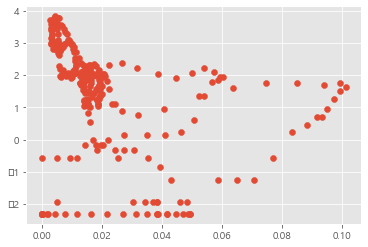

In [172]:
plt.scatter(X_train,y_train)

In [179]:
predy = model.predict(np.array(X_train).reshape(-1,1))

In [114]:
pd.DataFrame({'var':train.columns[:18], 'mse' : scores , 'coef' : coef}).sort_values(by='mse')

,var,mse,coef
5,1week_before_B_Sv,1.026538e+03,1.018345
14,2week_before_B_Sv,1.045539e+03,0.966471
6,1week_before_Density,1.237854e+03,3.331731
9,2week_before_AD_Cv,1.238531e+03,-7.637714
0,1week_before_AD_Cv,1.238532e+03,-7.406745
10,2week_before_AD_Pv,1.238555e+03,-14.932825
1,1week_before_AD_Pv,1.238555e+03,-14.330439
15,2week_before_Density,1.238615e+03,-0.738077
2,1week_before_AD_Sv,1.240964e+03,-11.564149
11,2week_before_AD_Sv,1.241038e+03,-11.966670


In [165]:
len(predy)
len(np.log(train.iloc[:,19]))

303

303

In [180]:
sam = pd.DataFrame({'actual':train.iloc[:,19], 'pred':predy,'date':pd.date_range(start='01/30/2020',end='11/27/2020')})

fig = px.line(sam, x="date", y=["actual","pred"])
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
              yaxis_showgrid=False,width=900, height=600,
              title='Density')

## 다소 선행

In [184]:
total['Date']

0     2020-01-30
1     2020-01-31
2     2020-02-01
3     2020-02-02
4     2020-02-03
         ...    
332   2020-12-27
333   2020-12-28
334   2020-12-29
335   2020-12-30
336   2020-12-31
Name: Date, Length: 337, dtype: datetime64[ns]

In [186]:
total[total['Date']=='2020-11-28']
total[total['Date']=='2020-11-29']
total[total['Date']=='2020-11-30']

,1week_before_AD_Cv,1week_before_AD_Pv,1week_before_AD_Sv,1week_before_AVG_COEF,1week_before_B_Cv,1week_before_B_Sv,1week_before_Density,1week_before_Modularity,1week_before_infected,2week_before_AD_Cv,2week_before_AD_Pv,2week_before_AD_Sv,2week_before_AVG_COEF,2week_before_B_Cv,2week_before_B_Sv,2week_before_Density,2week_before_Modularity,2week_before_infected,Date,infected
303,0.000098,0.000073,0.003471,4.293268,0.027672,1.500869,0.002908,0.005733,33.22449,0.000092,0.000069,0.00337,3.371991,0.026871,1.500844,0.002879,0.005681,36.877551,2020-11-28,46.571429


,1week_before_AD_Cv,1week_before_AD_Pv,1week_before_AD_Sv,1week_before_AVG_COEF,1week_before_B_Cv,1week_before_B_Sv,1week_before_Density,1week_before_Modularity,1week_before_infected,2week_before_AD_Cv,2week_before_AD_Pv,2week_before_AD_Sv,2week_before_AVG_COEF,2week_before_B_Cv,2week_before_B_Sv,2week_before_Density,2week_before_Modularity,2week_before_infected,Date,infected
304,0.000092,0.000069,0.003344,4.374457,0.026657,1.500837,0.0028,0.005524,35.122449,0.000089,0.000067,0.003313,3.538924,0.026416,1.50083,0.002825,0.005575,37.55102,2020-11-29,55.0


,1week_before_AD_Cv,1week_before_AD_Pv,1week_before_AD_Sv,1week_before_AVG_COEF,1week_before_B_Cv,1week_before_B_Sv,1week_before_Density,1week_before_Modularity,1week_before_infected,2week_before_AD_Cv,2week_before_AD_Pv,2week_before_AD_Sv,2week_before_AVG_COEF,2week_before_B_Cv,2week_before_B_Sv,2week_before_Density,2week_before_Modularity,2week_before_infected,Date,infected
305,0.000083,0.000062,0.003164,4.431349,0.025226,1.500792,0.002654,0.005241,38.693878,0.000087,0.000065,0.003254,3.709542,0.025946,1.500815,0.00277,0.005467,38.622449,2020-11-30,62.714286


In [182]:
sam = pd.DataFrame({'actual':y_test, 'pred':y_pred, 'date':pd.date_range(start='12/01/2020',end='12/31/2020')})

In [183]:
fig = px.line(sam, x="date", y=["actual","pred"])
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
              yaxis_showgrid=False,width=900, height=600,
              title='Density')

## 다소 선행

## 5. 결론
- 선형관계를 갖는 AVG_COEF와 AVG_INFECT는 Y변수와 linear model을 사용 시 mse를 매우 크게 낮춤 ( 상관관계가 매우 유의했기 때문에 ! )
- 하지만 그 외의 AD_INDEX , B_INDEX, Density , Modularity는 지수함수 형태를 띄므로 exponential regression 시 mse를 낮춤

- But linear regression이 확진자 수 예측에 훨씬 많은 기여를 하였음  : mse = 130 vs 274 

In [53]:
X_train, y_train = train[train.columns.difference(['Date','infected'])] , train['infected']
X_test, y_test = test[test.columns.difference(['Date','infected'])] , test['infected']

In [54]:
X_train.columns

Index(['1week_before_AD_Cv', '1week_before_AD_Pv', '1week_before_AD_Sv',
       '1week_before_AVG_COEF', '1week_before_B_Cv', '1week_before_B_Sv',
       '1week_before_Density', '1week_before_Modularity',
       '1week_before_infected', '2week_before_AD_Cv', '2week_before_AD_Pv',
       '2week_before_AD_Sv', '2week_before_AVG_COEF', '2week_before_B_Cv',
       '2week_before_B_Sv', '2week_before_Density', '2week_before_Modularity',
       '2week_before_infected'],
      dtype='object')

In [60]:
exp_fea = ['1week_before_AD_Cv', '1week_before_AD_Pv', '1week_before_AD_Sv', '1week_before_B_Cv', '1week_before_B_Sv',
       '1week_before_Density', '1week_before_Modularity','2week_before_AD_Cv', '2week_before_AD_Pv',
       '2week_before_AD_Sv',  '2week_before_B_Cv',
       '2week_before_B_Sv', '2week_before_Density', '2week_before_Modularity']

train[exp_fea] = np.exp(train[exp_fea])

In [61]:
test[exp_fea] = np.exp(test[exp_fea])

In [63]:
scores = []
coef = []
for i in range(18):
    X_train , y_train = train.iloc[:,i] , train.iloc[:,19] # 20번째 컬럼이 infected y변수
    X_test  , y_test  = test.iloc[:,i] , test.iloc[:,19]
    model = LinearRegression()
    model.fit(np.array(X_train).reshape(-1,1), y_train)
    y_pred = model.predict(np.array(X_test).reshape(-1,1))
    scores.append(mean_squared_error(y_test,y_pred))
    coef.append(model.coef_[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)